**Goal**: Develop an AI-powered agent, built on the LangGraph framework, that automatically analyzes and summarizes GitHub repositories based on their URL. The agent extracts metadata, README contents, and key insights to generate a concise, human-readable summary.

* **LLM used**: Mistral AI
* **Agent Framework**: LangGraph

**Install the packages**

In [ ]:
!pip install -U langchain-community langgraph langchain-anthropic tavily-python langgraph-checkpoint-sqlite
!pip install -qU langchain-mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing

**Import the packages**

In [ ]:
from typing_extensions import Literal
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt
import os
import json
import re
from typing import TypedDict, List, Dict, Optional
import base64
import requests
from langchain_mistralai import ChatMistralAI

**Get the API keys**

* MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
* GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

Define the State and add following functions
* fetch_repo_metadata -> To fetch the repo information
* summarize_repository -> To summarize the repository
* format output -> To format the summary in a proper human readable format

In [ ]:
# -- State definition -------------------------------------------------------
class State(TypedDict, total=False):
    repo_url: str
    owner: str
    repo: str
    branch: str
    readme: Optional[str]
    repo_stats: Optional[Dict]
    file_tree: Optional[List[Dict]]
    summary_json: Optional[Dict]
    error: Optional[str]
    final_output: str

# -- Step 1: Fetch README, repo stats and file tree ------------------------

# def parse_github_url(url: str) -> (str, str):
#     """
#     Safely parse a GitHub repository URL into (owner, repo) components.
#     Supports https, git@, and short 'owner/repo' formats.
#     """

#     # Handle cases where the input is mistakenly a dict (e.g., LangGraph state)
#     if isinstance(url, dict):
#         if "repo_url" in url:
#             url = url["repo_url"]
#         else:
#             raise ValueError("Expected a string or dict containing 'repo_url' key.")

#     if not isinstance(url, str):
#         raise ValueError(f"Expected string URL, got {type(url)}")

#     url = url.strip()

#     # Handle git@ style URLs
#     if url.startswith("git@") and ":" in url:
#         _, tail = url.split(":", 1)
#         owner, repo = tail.split("/", 1)

#     # Handle HTTPS URLs
#     elif url.startswith("http"):
#         parts = url.split("/")
#         if len(parts) < 5:
#             raise ValueError(f"Invalid GitHub URL: {url}")
#         owner = parts[3]
#         repo = parts[4] if len(parts) > 4 else ""

#     # Handle short "owner/repo" format
#     elif "/" in url:
#         owner, repo = url.split("/", 1)

#     else:
#         raise ValueError(f"Unrecognized GitHub repo URL format: {url}")

#     # Clean up repo name
#     repo = repo.rstrip("/ ")
#     if repo.endswith(".git"):
#         repo = repo[:-4]

#     return owner, repo


def fetch_repo_metadata(state: State) -> State:
    try:
        if "repo_url" not in state:
            return {**state, "error": "Please provide a GitHub repository URL in the state."}

        # Extract owner and repo directly from the URL
        repo_url = state["repo_url"].strip()
        parts = repo_url.split("/")
        if len(parts) < 5:
            return {**state, "error": f"Invalid GitHub URL format: {repo_url}"}
        owner, repo = parts[3], parts[4].replace(".git", "")

        token = os.getenv("GITHUB_TOKEN")
        headers = {"Accept": "application/vnd.github.v3+json"}
        if token:
            headers["Authorization"] = f"token {token}"

        session = requests.Session()
        session.headers.update(headers)

        # Fetch repo metadata
        repo_resp = session.get(f"https://api.github.com/repos/{owner}/{repo}")
        if repo_resp.status_code != 200:
            return {**state, "error": f"Failed to fetch repo metadata: {repo_resp.status_code} {repo_resp.text}"}
        repo_json = repo_resp.json()
        default_branch = repo_json.get("default_branch", "main")

        # Fetch README.md
        readme_resp = session.get(f"https://api.github.com/repos/{owner}/{repo}/readme")
        readme_text = None
        if readme_resp.status_code == 200:
            readme_json = readme_resp.json()
            if "content" in readme_json and readme_json.get("encoding") == "base64":
                try:
                    decoded = base64.b64decode(readme_json["content"]).decode("utf-8", errors="replace")
                    readme_text = decoded
                except Exception:
                    readme_text = None
        else:
            raw_url = f"https://raw.githubusercontent.com/{owner}/{repo}/{default_branch}/README.md"
            raw_resp = session.get(raw_url)
            if raw_resp.status_code == 200:
                readme_text = raw_resp.text

        # Fetch file tree
        tree_resp = session.get(f"https://api.github.com/repos/{owner}/{repo}/git/trees/{default_branch}?recursive=1")
        file_tree = []
        if tree_resp.status_code == 200:
            tree_json = tree_resp.json()
            for entry in tree_json.get("tree", []):
                file_tree.append({
                    "path": entry.get("path"),
                    "type": entry.get("type"),
                    "sha": entry.get("sha"),
                    "size": entry.get("size"),
                    "mode": entry.get("mode"),
                })
        else:
            contents_resp = session.get(f"https://api.github.com/repos/{owner}/{repo}/contents")
            if contents_resp.status_code == 200:
                for entry in contents_resp.json():
                    file_tree.append({
                        "path": entry.get("path"),
                        "type": entry.get("type"),
                        "size": entry.get("size"),
                        "sha": entry.get("sha"),
                        "download_url": entry.get("download_url"),
                    })

        new_state: State = {
            **state,
            "owner": owner,
            "repo": repo,
            "branch": default_branch,
            "readme": readme_text,
            "repo_stats": {
                "full_name": repo_json.get("full_name"),
                "description": repo_json.get("description"),
                "stars": repo_json.get("stargazers_count"),
                "forks": repo_json.get("forks_count"),
                "open_issues": repo_json.get("open_issues_count"),
                "watchers": repo_json.get("watchers_count"),
                "language": repo_json.get("language"),
            },
            "file_tree": file_tree,
        }
        return new_state

    except Exception as e:
        return {**state, "error": str(e)}



# -- Step 2: Summarize Repository ------------------------------------------

def summarize_repository(state: State) -> State:
    try:
        llm = ChatMistralAI(
            model="mistral-large-latest",
            api_key=os.environ["MISTRAL_API_KEY"],
            temperature=0.2
        )

        prompt = f"""
You are an AI that summarizes GitHub repositories.

Summarize the following repository using the provided metadata, README, and file structure.

Extract the following information:
1. Purpose of the repository
2. Key functionalities / modules
3. Primary programming languages and technologies
4. Notable files and their purpose
5. Predicted Tech Stack (frameworks, libraries, tools)

Respond strictly in JSON format:
{{
  "purpose": "...",
  "key_features": ["..."],
  "languages": ["..."],
  "notable_files": ["..."],
  "tech_stack_prediction": ["..."]
}}

Repository Metadata:
{state.get('repo_stats', {})}

README (excerpt):
\"\"\"{state.get('readme', '')[:2500]}\"\"\"

File Structure (top 20):
{[f['path'] for f in state.get('file_tree', [])[:20]]}
"""

        response = llm.invoke(prompt)
        raw_output = getattr(response, "content", str(response)).strip()

        # Debug log to inspect what the model returned
        # print("----- Raw model output (first 500 chars) -----")
        # print(raw_output[:500])
        # print("----------------------------------------------")

        # Remove markdown code fences or stray text
        cleaned = raw_output.replace("```json", "").replace("```", "").strip()

        # Extract the JSON block using regex
        match = re.search(r"\{[\s\S]*\}", cleaned)
        if not match:
            return {**state, "error": "No valid JSON found in model output. Please check printed output."}

        json_str = match.group(0)

        # Parse JSON safely
        summary_json = json.loads(json_str)

        return {**state, "summary_json": summary_json}

    except json.JSONDecodeError as e:
        return {**state, "error": f"JSON parsing failed: {e}"}
    except Exception as e:
        return {**state, "error": str(e)}

def format_output(state: State) -> State:
    if "summary_json" not in state:
        return {**state, "error": "No summary_json found in state."}

    summary = state["summary_json"]

    formatted = f"🏗️ **Repository Purpose:**\n{summary.get('purpose', 'N/A')}\n\n"

    if summary.get("key_features"):
        formatted += "✨ **Key Features:**\n" + "\n".join(f"- {f}" for f in summary["key_features"]) + "\n\n"

    if summary.get("languages"):
        formatted += "🧠 **Languages Used:**\n" + ", ".join(summary["languages"]) + "\n\n"

    if summary.get("notable_files"):
        formatted += "📁 **Notable Files:**\n" + "\n".join(f"- {f}" for f in summary["notable_files"]) + "\n\n"

    if summary.get("tech_stack_prediction"):
        tech_items = []
        for item in summary["tech_stack_prediction"]:
            if isinstance(item, dict):
                # Handle dicts with 'name' or similar keys
                tech_items.append(item.get("name", str(item)))
            else:
                tech_items.append(str(item))
        formatted += "⚙️ **Predicted Tech Stack:**\n" + ", ".join(tech_items) + "\n"

    return {**state, "final_output": formatted}



# -- Test locally -----------------------------------------------------------
if __name__ == "__main__":
    s: State = {"repo_url": "https://github.com/HarshavardhanaNaganagoudar/tryon-ai"}

    # Step 1 — Fetch repo metadata
    meta = fetch_repo_metadata(s)
    if meta.get("error"):
        print("❌ Error in metadata:", meta["error"])
    else:
        print("✅ Metadata fetched successfully")

        # Step 2 — Summarize repository
        summary_state = summarize_repository(meta)
        if summary_state.get("error"):
            print("❌ Error in summarization:", summary_state["error"])
        else:
            print("✅ Summarization successful")

            # Step 3 — Format final output
            formatted_state = format_output(summary_state)
            if formatted_state.get("error"):
                print("❌ Error in formatting:", formatted_state["error"])
            else:
                print("\n\n================== 📘 FINAL SUMMARY ==================\n")
                print(formatted_state["final_output"])
                print("\n=====================================================\n")

# Later, this will be added into the LangGraph builder chain


✅ Metadata fetched successfully
✅ Summarization successful


================== 📘 FINAL SUMMARY ==================

🏗️ **Repository Purpose:**
An AI-powered **virtual try-on system** that integrates with the Google Cloud's Online Boutique microservices demo. Users can browse products, upload their photos, and see AI-generated try-on images using the **Google Gemini API**. The system is containerized and deployed on **Google Kubernetes Engine (GKE)** with a microservices architecture.

✨ **Key Features:**
- Product browsing via the **Online Boutique** frontend (Go-based)
- User photo upload for virtual try-on functionality
- AI-generated try-on images using **Google Gemini API** (combines product + user images)
- Containerized **Flask microservice** for handling try-on logic
- Deployment on **GKE Autopilot** with Kubernetes manifests
- Seamless integration into the existing Online Boutique UI (HTML templates + CSS styling)
- LoadBalancer-based frontend for scalability
- Demo-ready with 

From above it can been seen that the functions are working as expected when tested without agentic framework, next step is to build the framework.

**Create the nodes and edges to create an end to end LangGraph Agentic Framework**

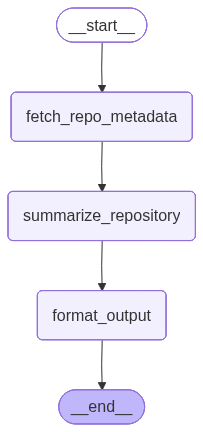

In [ ]:
builder  = StateGraph(State)
# builder.add_node('parse_github_url', parse_github_url)
builder.add_node('fetch_repo_metadata', fetch_repo_metadata)
builder.add_node('summarize_repository', summarize_repository)
builder.add_node('format_output', format_output)
# builder.add_edge(START, 'parse_github_url')
builder.add_edge(START, 'fetch_repo_metadata')
builder.add_edge('fetch_repo_metadata', 'summarize_repository')
builder.add_edge('summarize_repository', 'format_output')
builder.add_edge('format_output', END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

**Testing by invoking the graph and a repo url**

In [ ]:
initial_state = State(
    repo_url = "https://github.com/HarshavardhanaNaganagoudar/Carbon-Compass"
)
result = graph.invoke(initial_state)
print(result["final_output"])

🏗️ **Repository Purpose:**
Carbon Compass is a tool designed to visualize the climate impact of everyday lifestyle choices by plotting them on a 2D compass. The X-axis represents the ease of change (Easy ↔ Hard), while the Y-axis represents the CO₂ footprint (Low ↔ High). The goal is to help users make more informed, sustainable decisions through interactive and AI-powered visualizations.

✨ **Key Features:**
- 2D **Climate Impact Compass** – Plots user-provided lifestyle choices on an axis of *ease of change* vs. *CO₂ footprint*
- AI-powered classification of lifestyle choices (via LLM or heuristic) to assign coordinates in the range **[-1, 1]²**
- Interactive **Gradio-based UI** for browser-based usage without requiring coding knowledge
- Quadrant-based **color-coded visualization** for intuitive interpretation of impact levels
- Outputs a **PNG visualization** of the plotted choices for easy sharing or reference

🧠 **Languages Used:**
Python (primary, inferred from Jupyter Notebook 

The AI agent is working as expected by giving concise, human friendly readable summary.

**Conclusion**

This AI agent turns any GitHub repository into an instant, human-readable summary bridging the gap between raw code and clear understanding through LangGraph’s powerful agentic workflows.